In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from scipy.ndimage.measurements import label
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
vehicle_images = glob.glob('vehicles/*/*.png')
#vehicle_images2 = glob.glob('vehicles/GTI_Right/*.png')
#vehicle_images3 = glob.glob('vehicles/GTI_Left/*.png')
#vehicle_images4 = glob.glob('vehicles/GTI_Far/*.png')

#vehicle_images = vehicle_images1+vehicle_images2+vehicle_images3+vehicle_images4
nonvehicle_images = glob.glob('non-vehicles/*/*.png')

vehicles = []
nonvehicles = []
for image in vehicle_images:
    vehicles.append(cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB))
for image in nonvehicle_images:    
    nonvehicles.append(cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB))

In [3]:
def labels(x,ifvehicles):
    if ifvehicles == True:
        return np.array([1 for _ in range(len(x))])
    else:
        return np.array([0 for _ in range(len(x))])

In [4]:
images = np.concatenate((vehicles,nonvehicles))
vehicles_labels = labels(vehicles,True)
nonvehicles_labels = labels(nonvehicles,False)
labels = np.concatenate((vehicles_labels,nonvehicles_labels))

In [5]:
print(len(nonvehicles))

8968


In [6]:
def normalization(x):
    return (x-min(x))/(max(x)-min(x))

In [7]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


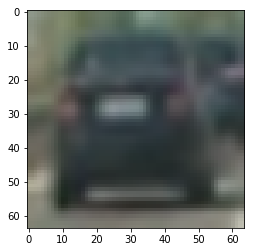

In [8]:
plt.imshow(images[2])

In [9]:
features, hog_image = hog(images[2][:,:,0], orientations=9, 
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), 
                          transform_sqrt=True, 
                          visualise=True, feature_vector=False)

/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


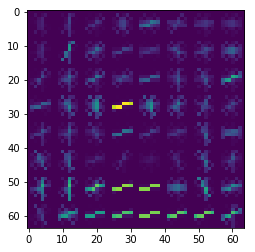

In [10]:
plt.imshow(hog_image)

In [11]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [12]:
def color_hist(img, nbins=32, bins_range=(0, 256), moreDetail=False):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    if moreDetail == True:
        return hist_features, bin_centers, channel1_hist, channel2_hist, channel3_hist
    return hist_features

In [13]:
def extract_features(img, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    #features = []
    # Iterate through the list of images
    #for img in imgs:
    file_features = []
    # Read in each one by one
    feature_image = img
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        feature_image = cv2.cvtColor(feature_image, eval('cv2.COLOR_RGB2{}'.format(color_space)))  

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(normalization(spatial_features))
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(normalization(hist_features))
    if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
    features = np.concatenate(file_features)
    # Return list of feature vectors
    return features

In [15]:
def train_model(images,labels,color_space='YCrCb',spatial_size=(32, 32),
                hist_bins=32,orient=9,pix_per_cell=8,cell_per_block=2,
                hog_channel='ALL',spatial_feat=True,hist_feat=True,hog_feat=True):
    
    features = []
    for image in images:
        features.append(extract_features(image,color_space='YCrCb',spatial_size=(32, 32),
                                         hist_bins=32,orient=9,pix_per_cell=8, cell_per_block=2, 
                                         hog_channel='ALL',spatial_feat=True,hist_feat=True,hog_feat=True))
    #nfeatures = np.vstack(features)
    
    #features = extract_features(imgs,color_space='RGB',spatial_size=(32, 32),
                                #hist_bins=32,orient=9,pix_per_cell=8, cell_per_block=2, 
                                #hog_channel='ALL',spatial_feat=True,hist_feat=True,hog_feat=True)
    print(np.array(features).shape)
    x_train,x_test,y_train,y_test = train_test_split(features,labels,test_size=0.4,random_state=0)
    
    
    clf = LinearSVC()
    klf = clf.fit(x_train,y_train)
    sco = klf.score(x_test,y_test)
    return klf,sco

In [16]:
clf,sco = train_model(images,labels)

/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(17760, 8460)


In [17]:
sco

0.99380630630630629

In [18]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    # If x and/or y start/stop positions not defined, set to image size
    if (x_start_stop[0] is None) or (x_start_stop[1] is None):
        x_start_stop = [0,img.shape[1]]
    if (y_start_stop[0] is None) or (y_start_stop[1] is None):
        y_start_stop = [0,img.shape[0]]
    # Compute the span of the region to be searched   
    xSpan = x_start_stop[1] - x_start_stop[0]
    ySpan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nxPixPerStep = np.int(xy_window[0]*(1 - xy_overlap[0]))
    nyPixPerStep = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nxWindows = np.int(xSpan/nxPixPerStep) - 1
    nyWindows = np.int(ySpan/nyPixPerStep) - 1
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(nyWindows):
        for xs in range(nxWindows):
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
            # Calculate window position
            startx = xs*nxPixPerStep + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*nyPixPerStep + y_start_stop[0]
            endy = starty + xy_window[1]
        # Calculate each window position
        # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [19]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [20]:
def search_windows(img, windows, clf, color_space='YCrCb', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        #test_features = scaler.transform(np.array(features).reshape(1, -1))
        test_features = features
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        #print(prediction)
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

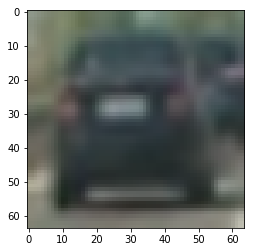

In [21]:
plt.imshow(images[2])

In [22]:
cv2.imwrite('car.png',images[2])

True

In [23]:
#vehicle_images = glob.glob('vehicles/GTI_Right/image*.png')
test_images = glob.glob('test_images/test*.jpg')
images = []
for image in test_images:
    images.append(cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB))

In [24]:
windows1 = slide_window(images[5], x_start_stop=[None, None], y_start_stop=[400, 660], 
                    xy_window=(256, 256), xy_overlap=(0.5, 0.5))

In [25]:
windows2 = slide_window(images[5], x_start_stop=[None, None], 
                           y_start_stop=[400, 660], xy_window=(128, 128), 
                           xy_overlap=(0.5, 0.5))

In [26]:
windows3 = slide_window(images[5], x_start_stop=[None, None], 
                           y_start_stop=[400, 660], xy_window=(96, 96), 
                           xy_overlap=(0.5, 0.5))

In [27]:
windows = windows1+windows2+windows3

In [28]:
on_windows = search_windows(images[4], windows, clf, color_space='YCrCb', 
                            spatial_size=(32, 32), hist_bins=32, 
                            hist_range=(0, 256), orient=9, 
                            pix_per_cell=8, cell_per_block=2, 
                            hog_channel='ALL', spatial_feat=True, 
                            hist_feat=True, hog_feat=True)

/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/zhaomingchuan/anaconda3/lib/pytho

/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) i

/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) i

/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) i

/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) i

/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/zhaomingchuan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) i

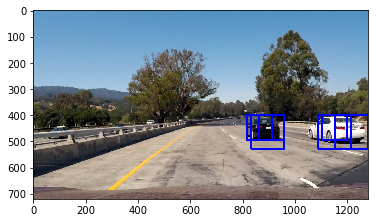

In [29]:
plt.imshow(draw_boxes(images[0], on_windows, color=(0, 0, 255), thick=6))

In [30]:
im = draw_boxes(images[0], on_windows, color=(0, 0, 255), thick=6)

In [31]:
cv2.imwrite('kernel.png',cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

True

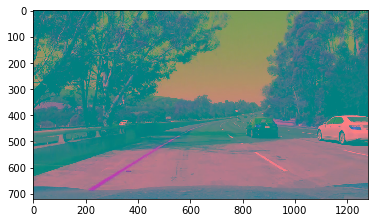

In [32]:
plt.imshow(cv2.cvtColor(images[4],cv2.COLOR_RGB2YUV))

In [33]:
def add_heat(heat, boxlist):
    # Iterate through list of bboxes
    for box in boxlist:
        # Add += 1 for all pixels inside each bbox
        heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heat
    
def apply_threshold(heatmap, threshold):
    heatMap = np.copy(heatmap)
    # Zero out pixels below the threshold
    heatMap[heatMap < threshold] = 0
    # Return thresholded map
    return heatMap

def draw_labeled_bboxes(img, labels):
    for carNumber in range(1, labels[1]+1):
        nonzero = (labels[0] == carNumber).nonzero()
        
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        #p0l,p0r = bbox[0]
        #p1l,p1r = bbox[1]
        #p0l = np.int(p0l / scale)
        #p0r = np.int(p0r / scale)
        #p1l = np.int(p1l * scale)
        #p1r = np.int(p1r * scale)
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 3)
        
        # cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
    return img

2 cars found


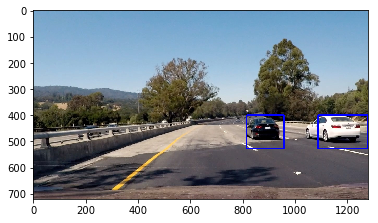

In [37]:
heat = np.zeros_like(images[0][:,:,0]).astype(np.float)
heat = add_heat(heat,on_windows)
heat = apply_threshold(heat,1)
heatmap = np.clip(heat,0,255)
heatmap = apply_threshold(heatmap, 1)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(images[3]),labels)
print(labels[1], 'cars found')
#plt.imshow(labels[0], cmap='gray')
plt.imshow(draw_img)

In [38]:
cv2.imwrite('result.png',cv2.cvtColor(draw_img,cv2.COLOR_BGR2RGB))

True

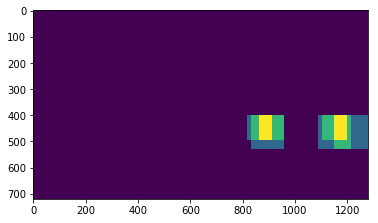

In [39]:
plt.imshow(heatmap)

In [41]:
cv2.imwrite('heatmap.png',25*heatmap)

True

In [72]:
pre_heatmap = []

In [73]:
def pipeline(image):
    global pre_heatmap
    
    #image = image.astype(np.float32)/255
    
    windows1 = slide_window(image, x_start_stop=[660, 1280], 
                           y_start_stop=[400, 660], xy_window=(96, 96), 
                           xy_overlap=(0.7, 0.7))
    
    windows2 = slide_window(image, x_start_stop=[660, 1280], 
                           y_start_stop=[400, 660], xy_window=(128, 128), 
                           xy_overlap=(0.7, 0.7))
    
    windows3 = slide_window(image, x_start_stop=[660, 1280], 
                           y_start_stop=[400, 660], xy_window=(84, 84), 
                           xy_overlap=(0.7, 0.7))
    
    #windows4 = slide_window(image, x_start_stop=[600, 1250], 
    #                       y_start_stop=[400, 650], xy_window=(60, 60), 
    #                       xy_overlap=(0.5, 0.5))
    
    #windows5 = slide_window(image, x_start_stop=[600, 1250], 
    #                       y_start_stop=[400, 650], xy_window=(80, 80), 
    #                       xy_overlap=(0.5, 0.5))
    
    windows = windows1+windows2+windows3#+windows4+windows5
    
    
    on_windows = search_windows(image, windows, clf, color_space='YCrCb', 
                                spatial_size=(32, 32), hist_bins=32, 
                                hist_range=(0, 256), orient=9, 
                                pix_per_cell=8, cell_per_block=2, 
                                hog_channel='ALL', spatial_feat=True, 
                                hist_feat=True, hog_feat=True)
    
    heat = np.zeros_like(images[0][:,:,0]).astype(np.float)
    heat = add_heat(heat,on_windows)
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat,0,255)
    #heatmap = apply_threshold(heatmap,5)

    pre_heatmap.append(heatmap)
    
    if len(pre_heatmap) >=20:
        heatmap = 0.9*np.mean(pre_heatmap[-20:-1],axis=0)
        #heatmap = 0.7*np.mean(pre_heatmap[-15:-5],axis=0) + np.mean(pre_heatmap[-5:-1])

    heatmap = apply_threshold(heatmap,1)
    labels = label(heatmap)
    #global pre_labels
    #if len(pre_labels)
    draw_img = draw_labeled_bboxes(np.copy(image),labels)
    #print(labels[1], 'cars found')
    #plt.imshow(labels[0], cmap='gray')
    #plt.imshow(draw_img)
    #result =cv2.putText(img=np.copy(draw_img), text='{}{}'.format(labels[1],' cars found'), org=(100,100),fontFace=2, fontScale=2, color=(255,255,255), thickness=3)

    return draw_img

In [74]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [75]:
white_output = 'project_video_ouput_f.mp4'
#white_output = 'project_video.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_ouput_f.mp4
[MoviePy] Writing video project_video_ouput_f.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:02<1:02:21,  2.97s/it]

  0%|          | 2/1261 [00:05<1:02:04,  2.96s/it]

  0%|          | 3/1261 [00:08<1:00:13,  2.87s/it]

  0%|          | 4/1261 [00:11<1:03:13,  3.02s/it]

  0%|          | 5/1261 [00:14<1:02:16,  2.97s/it]

  0%|          | 6/1261 [00:17<1:01:40,  2.95s/it]

  1%|          | 7/1261 [00:20<1:01:28,  2.94s/it]

  1%|          | 8/1261 [00:23<1:00:16,  2.89s/it]

  1%|          | 9/1261 [00:26<58:54,  2.82s/it]  

  1%|          | 10/1261 [00:28<57:50,  2.77s/it]

  1%|          | 11/1261 [00:31<57:06,  2.74s/it]

  1%|          | 12/1261 [00:34<57:06,  2.74s/it]

  1%|          | 13/1261 [00:37<58:55,  2.83s/it]

  1%|          | 14/1261 [00:40<59:32,  2.86s/it]

  1%|          | 15/1261 [00:42<59:25,  2.86s/it]

  1%|▏         | 16/1261 [00:45<59:07,  2.85s/it]

  1%|▏         | 17/1261 [00:48<59:28,  2.87s/it]

  1%|▏         | 18/1261 [00:51<59:27,  2.87s/it]

  2%|▏         | 19/1261 [00:

 11%|█▏        | 142/1261 [06:35<52:34,  2.82s/it]

 11%|█▏        | 143/1261 [06:38<53:14,  2.86s/it]

 11%|█▏        | 144/1261 [06:41<52:34,  2.82s/it]

 11%|█▏        | 145/1261 [06:44<52:02,  2.80s/it]

 12%|█▏        | 146/1261 [06:47<52:34,  2.83s/it]

 12%|█▏        | 147/1261 [06:49<52:18,  2.82s/it]

 12%|█▏        | 148/1261 [06:52<51:58,  2.80s/it]

 12%|█▏        | 149/1261 [06:55<51:44,  2.79s/it]

 12%|█▏        | 150/1261 [06:58<51:43,  2.79s/it]

 12%|█▏        | 151/1261 [07:00<51:22,  2.78s/it]

 12%|█▏        | 152/1261 [07:03<51:14,  2.77s/it]

 12%|█▏        | 153/1261 [07:06<50:59,  2.76s/it]

 12%|█▏        | 154/1261 [07:09<50:50,  2.76s/it]

 12%|█▏        | 155/1261 [07:11<50:46,  2.75s/it]

 12%|█▏        | 156/1261 [07:14<50:38,  2.75s/it]

 12%|█▏        | 157/1261 [07:17<51:33,  2.80s/it]

 13%|█▎        | 158/1261 [07:20<53:43,  2.92s/it]

 13%|█▎        | 159/1261 [07:23<55:10,  3.00s/it]

 13%|█▎        | 160/1261 [07:26<53:45,  2.93s/it]

 13%|█▎     

 22%|██▏       | 283/1261 [13:32<47:07,  2.89s/it]

 23%|██▎       | 284/1261 [13:35<47:16,  2.90s/it]

 23%|██▎       | 285/1261 [13:38<47:09,  2.90s/it]

 23%|██▎       | 286/1261 [13:40<47:08,  2.90s/it]

 23%|██▎       | 287/1261 [13:43<47:10,  2.91s/it]

 23%|██▎       | 288/1261 [13:46<47:01,  2.90s/it]

 23%|██▎       | 289/1261 [13:49<46:59,  2.90s/it]

 23%|██▎       | 290/1261 [13:52<46:59,  2.90s/it]

 23%|██▎       | 291/1261 [13:55<47:12,  2.92s/it]

 23%|██▎       | 292/1261 [13:58<47:22,  2.93s/it]

 23%|██▎       | 293/1261 [14:01<47:17,  2.93s/it]

 23%|██▎       | 294/1261 [14:04<47:08,  2.92s/it]

 23%|██▎       | 295/1261 [14:07<46:59,  2.92s/it]

 23%|██▎       | 296/1261 [14:10<46:56,  2.92s/it]

 24%|██▎       | 297/1261 [14:13<46:59,  2.93s/it]

 24%|██▎       | 298/1261 [14:16<46:57,  2.93s/it]

 24%|██▎       | 299/1261 [14:18<46:56,  2.93s/it]

 24%|██▍       | 300/1261 [14:21<46:53,  2.93s/it]

 24%|██▍       | 301/1261 [14:24<46:45,  2.92s/it]

 24%|██▍    

 34%|███▎      | 424/1261 [20:26<40:27,  2.90s/it]

 34%|███▎      | 425/1261 [20:29<40:25,  2.90s/it]

 34%|███▍      | 426/1261 [20:32<40:15,  2.89s/it]

 34%|███▍      | 427/1261 [20:35<40:08,  2.89s/it]

 34%|███▍      | 428/1261 [20:38<40:06,  2.89s/it]

 34%|███▍      | 429/1261 [20:41<40:00,  2.89s/it]

 34%|███▍      | 430/1261 [20:44<40:01,  2.89s/it]

 34%|███▍      | 431/1261 [20:47<39:58,  2.89s/it]

 34%|███▍      | 432/1261 [20:49<39:53,  2.89s/it]

 34%|███▍      | 433/1261 [20:52<39:41,  2.88s/it]

 34%|███▍      | 434/1261 [20:55<39:26,  2.86s/it]

 34%|███▍      | 435/1261 [20:58<39:17,  2.85s/it]

 35%|███▍      | 436/1261 [21:01<39:04,  2.84s/it]

 35%|███▍      | 437/1261 [21:04<39:01,  2.84s/it]

 35%|███▍      | 438/1261 [21:06<38:59,  2.84s/it]

 35%|███▍      | 439/1261 [21:09<38:51,  2.84s/it]

 35%|███▍      | 440/1261 [21:12<38:55,  2.84s/it]

 35%|███▍      | 441/1261 [21:15<38:49,  2.84s/it]

 35%|███▌      | 442/1261 [21:18<38:48,  2.84s/it]

 35%|███▌   

 45%|████▍     | 565/1261 [27:01<31:20,  2.70s/it]

 45%|████▍     | 566/1261 [27:03<31:17,  2.70s/it]

 45%|████▍     | 567/1261 [27:06<31:12,  2.70s/it]

 45%|████▌     | 568/1261 [27:09<30:59,  2.68s/it]

 45%|████▌     | 569/1261 [27:11<30:46,  2.67s/it]

 45%|████▌     | 570/1261 [27:14<30:39,  2.66s/it]

 45%|████▌     | 571/1261 [27:17<30:24,  2.64s/it]

 45%|████▌     | 572/1261 [27:19<30:08,  2.62s/it]

 45%|████▌     | 573/1261 [27:22<29:57,  2.61s/it]

 46%|████▌     | 574/1261 [27:24<29:53,  2.61s/it]

 46%|████▌     | 575/1261 [27:27<29:48,  2.61s/it]

 46%|████▌     | 576/1261 [27:30<29:42,  2.60s/it]

 46%|████▌     | 577/1261 [27:32<29:28,  2.59s/it]

 46%|████▌     | 578/1261 [27:35<29:27,  2.59s/it]

 46%|████▌     | 579/1261 [27:37<29:15,  2.57s/it]

 46%|████▌     | 580/1261 [27:40<29:21,  2.59s/it]

 46%|████▌     | 581/1261 [27:42<29:26,  2.60s/it]

 46%|████▌     | 582/1261 [27:45<29:27,  2.60s/it]

 46%|████▌     | 583/1261 [27:48<29:32,  2.61s/it]

 46%|████▋  

 56%|█████▌    | 706/1261 [33:13<24:48,  2.68s/it]

 56%|█████▌    | 707/1261 [33:15<24:55,  2.70s/it]

 56%|█████▌    | 708/1261 [33:18<24:53,  2.70s/it]

 56%|█████▌    | 709/1261 [33:21<24:40,  2.68s/it]

 56%|█████▋    | 710/1261 [33:23<24:36,  2.68s/it]

 56%|█████▋    | 711/1261 [33:26<24:31,  2.68s/it]

 56%|█████▋    | 712/1261 [33:29<24:24,  2.67s/it]

 57%|█████▋    | 713/1261 [33:31<24:22,  2.67s/it]

 57%|█████▋    | 714/1261 [33:34<24:15,  2.66s/it]

 57%|█████▋    | 715/1261 [33:37<24:11,  2.66s/it]

 57%|█████▋    | 716/1261 [33:39<24:06,  2.65s/it]

 57%|█████▋    | 717/1261 [33:42<24:02,  2.65s/it]

 57%|█████▋    | 718/1261 [33:45<24:04,  2.66s/it]

 57%|█████▋    | 719/1261 [33:47<24:07,  2.67s/it]

 57%|█████▋    | 720/1261 [33:50<24:03,  2.67s/it]

 57%|█████▋    | 721/1261 [33:53<24:00,  2.67s/it]

 57%|█████▋    | 722/1261 [33:55<23:55,  2.66s/it]

 57%|█████▋    | 723/1261 [33:58<23:51,  2.66s/it]

 57%|█████▋    | 724/1261 [34:01<23:56,  2.67s/it]

 57%|█████▋ 

 67%|██████▋   | 839/1261 [7:14:12<19:29,  2.77s/it]

 67%|██████▋   | 840/1261 [7:14:14<19:08,  2.73s/it]

 67%|██████▋   | 841/1261 [7:14:17<18:54,  2.70s/it]

 67%|██████▋   | 842/1261 [7:14:19<18:42,  2.68s/it]

 67%|██████▋   | 843/1261 [7:14:22<18:36,  2.67s/it]

 67%|██████▋   | 844/1261 [7:14:25<18:27,  2.66s/it]

 67%|██████▋   | 845/1261 [7:14:27<18:18,  2.64s/it]

 67%|██████▋   | 846/1261 [7:14:30<18:11,  2.63s/it]

 67%|██████▋   | 847/1261 [7:14:33<18:04,  2.62s/it]

 67%|██████▋   | 848/1261 [7:14:35<18:01,  2.62s/it]

 67%|██████▋   | 849/1261 [7:14:38<18:02,  2.63s/it]

 67%|██████▋   | 850/1261 [7:14:40<17:58,  2.62s/it]

 67%|██████▋   | 851/1261 [7:14:43<17:58,  2.63s/it]

 68%|██████▊   | 852/1261 [7:14:46<18:02,  2.65s/it]

 68%|██████▊   | 853/1261 [7:14:48<18:00,  2.65s/it]

 68%|██████▊   | 854/1261 [7:14:51<17:55,  2.64s/it]

 68%|██████▊   | 855/1261 [7:14:54<17:53,  2.64s/it]

 68%|██████▊   | 856/1261 [7:14:56<17:51,  2.65s/it]

 68%|██████▊   | 857/1261 [7

 77%|███████▋  | 975/1261 [7:20:31<14:46,  3.10s/it]

 77%|███████▋  | 976/1261 [7:20:34<14:18,  3.01s/it]

 77%|███████▋  | 977/1261 [7:20:37<13:49,  2.92s/it]

 78%|███████▊  | 978/1261 [7:20:40<13:53,  2.95s/it]

 78%|███████▊  | 979/1261 [7:20:43<13:48,  2.94s/it]

 78%|███████▊  | 980/1261 [7:20:46<13:47,  2.95s/it]

 78%|███████▊  | 981/1261 [7:20:49<13:33,  2.91s/it]

 78%|███████▊  | 982/1261 [7:20:51<13:37,  2.93s/it]

 78%|███████▊  | 983/1261 [7:20:55<14:23,  3.10s/it]

 78%|███████▊  | 984/1261 [7:20:58<14:14,  3.08s/it]

 78%|███████▊  | 985/1261 [7:21:01<13:53,  3.02s/it]

 78%|███████▊  | 986/1261 [7:21:04<13:34,  2.96s/it]

 78%|███████▊  | 987/1261 [7:21:07<13:20,  2.92s/it]

 78%|███████▊  | 988/1261 [7:21:09<13:02,  2.87s/it]

 78%|███████▊  | 989/1261 [7:21:12<13:13,  2.92s/it]

 79%|███████▊  | 990/1261 [7:21:15<13:17,  2.94s/it]

 79%|███████▊  | 991/1261 [7:21:18<13:18,  2.96s/it]

 79%|███████▊  | 992/1261 [7:21:21<13:22,  2.98s/it]

 79%|███████▊  | 993/1261 [7

 88%|████████▊ | 1109/1261 [7:26:30<06:40,  2.63s/it]

 88%|████████▊ | 1110/1261 [7:26:33<06:37,  2.63s/it]

 88%|████████▊ | 1111/1261 [7:26:35<06:37,  2.65s/it]

 88%|████████▊ | 1112/1261 [7:26:38<06:56,  2.80s/it]

 88%|████████▊ | 1113/1261 [7:26:41<06:47,  2.76s/it]

 88%|████████▊ | 1114/1261 [7:26:44<06:37,  2.70s/it]

 88%|████████▊ | 1115/1261 [7:26:46<06:29,  2.67s/it]

 89%|████████▊ | 1116/1261 [7:26:49<06:23,  2.65s/it]

 89%|████████▊ | 1117/1261 [7:26:51<06:20,  2.64s/it]

 89%|████████▊ | 1118/1261 [7:26:54<06:15,  2.63s/it]

 89%|████████▊ | 1119/1261 [7:26:57<06:11,  2.62s/it]

 89%|████████▉ | 1120/1261 [7:26:59<06:07,  2.61s/it]

 89%|████████▉ | 1121/1261 [7:27:02<06:11,  2.65s/it]

 89%|████████▉ | 1122/1261 [7:27:05<06:11,  2.68s/it]

 89%|████████▉ | 1123/1261 [7:27:07<06:07,  2.66s/it]

 89%|████████▉ | 1124/1261 [7:27:10<06:10,  2.70s/it]

 89%|████████▉ | 1125/1261 [7:27:13<06:12,  2.74s/it]

 89%|████████▉ | 1126/1261 [7:27:16<06:26,  2.86s/it]

 89%|█████

 99%|█████████▊| 1243/1261 [7:32:59<00:53,  2.96s/it]

 99%|█████████▊| 1244/1261 [7:33:03<00:51,  3.02s/it]

 99%|█████████▊| 1245/1261 [7:33:05<00:47,  3.00s/it]

 99%|█████████▉| 1246/1261 [7:33:08<00:44,  2.99s/it]

 99%|█████████▉| 1247/1261 [7:33:11<00:41,  2.95s/it]

 99%|█████████▉| 1248/1261 [7:33:14<00:38,  2.94s/it]

 99%|█████████▉| 1249/1261 [7:33:17<00:35,  2.92s/it]

 99%|█████████▉| 1250/1261 [7:33:20<00:31,  2.91s/it]

 99%|█████████▉| 1251/1261 [7:33:23<00:29,  2.90s/it]

 99%|█████████▉| 1252/1261 [7:33:26<00:26,  2.89s/it]

 99%|█████████▉| 1253/1261 [7:33:29<00:23,  2.89s/it]

 99%|█████████▉| 1254/1261 [7:33:32<00:20,  2.89s/it]

100%|█████████▉| 1255/1261 [7:33:34<00:17,  2.88s/it]

100%|█████████▉| 1256/1261 [7:33:37<00:14,  2.87s/it]

100%|█████████▉| 1257/1261 [7:33:40<00:11,  2.89s/it]

100%|█████████▉| 1258/1261 [7:33:43<00:09,  3.01s/it]

100%|█████████▉| 1259/1261 [7:33:46<00:05,  2.99s/it]

100%|█████████▉| 1260/1261 [7:33:49<00:02,  2.95s/it]



[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_ouput_f.mp4 

CPU times: user 56min 46s, sys: 1min 47s, total: 58min 33s
Wall time: 7h 33min 51s
